In [1]:
%matplotlib inline
import nivapy3 as nivapy
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

# Styling
plt.rcParams['axes.formatter.useoffset'] = False
plt.style.use('ggplot')

# Inle Lake: initial data exploration

Andreas and Marit have compiled a dataset for Inle Lake, spanning the period from 2014 to 2017 (see e-mails from Andreas received 05.02.2019 and 06.02.2019 for details). This notebook performs some basic data exploration as a precursor to more detailed statistical analysis.

There are three main data components:

 1. **Macrophytes**. Abundance scores for each taxon on a semi-quantitative scale: 1, rare; 2, scattered; 3, common; 4, locally dominant; 5, dominant. Intermediate classes are reported as e.g. 2.5; 0.5 is used to indicate "*drifting specimens*"; and -1 is used to indicate "*present but not quantified*". There is also an overall count of the number of species at each location (i.e. taxon diversity, not allowing for the abundance scores). A common approach seems to be to take the **cube** of this semi-quantitaive data and then treat it as quantitative (c.f. Susi's ECOREG projec) - see e-mail from Marit received 05.02.2019
 
 2. **Phytoplankton**. Quantitative biomass values for each taxon, plus an overall biomass score for each site-date combination, obtained by summing the biomass values for each taxon
 
 3. **Physico-chemical**. Depth, temperature, pH & conductivity, plus O2, silicate and "standard" nutrients (N, P and C)
 
## 1. Data tidying

I have transposed all the basic datasets so that each row corresponds to a single site-date combination. I have also replaced any ´'-'´ or ´'?'´ entries with NaN, and converted data types where appropriate (e.g. text to number or text to date).

Note that the dates in the macrophyte dataset are only specified to month (not day) accuracy. In order to link the datasets together, I will need the full dates for the macrophyte surveys (or we'll need to aggregate some of the other survey results to monthly resolution).

In [2]:
# Data source
in_xlsx = r'../data/inle_data_jes_tidied.xlsx'

## 2. Data distributions and internal relationships

The following code explores each dataset separately.

### 2.1. Physico-chemical data

**Note:** The code below replaces any LOD values (both ´'<'´ and ´'>'´) with the LOD itself. This can be changed later if desired. I've also grouped the sampling dates into "autumn" (November) versus spring (February and March).

#### 2.1.1. Seasonal boxplots

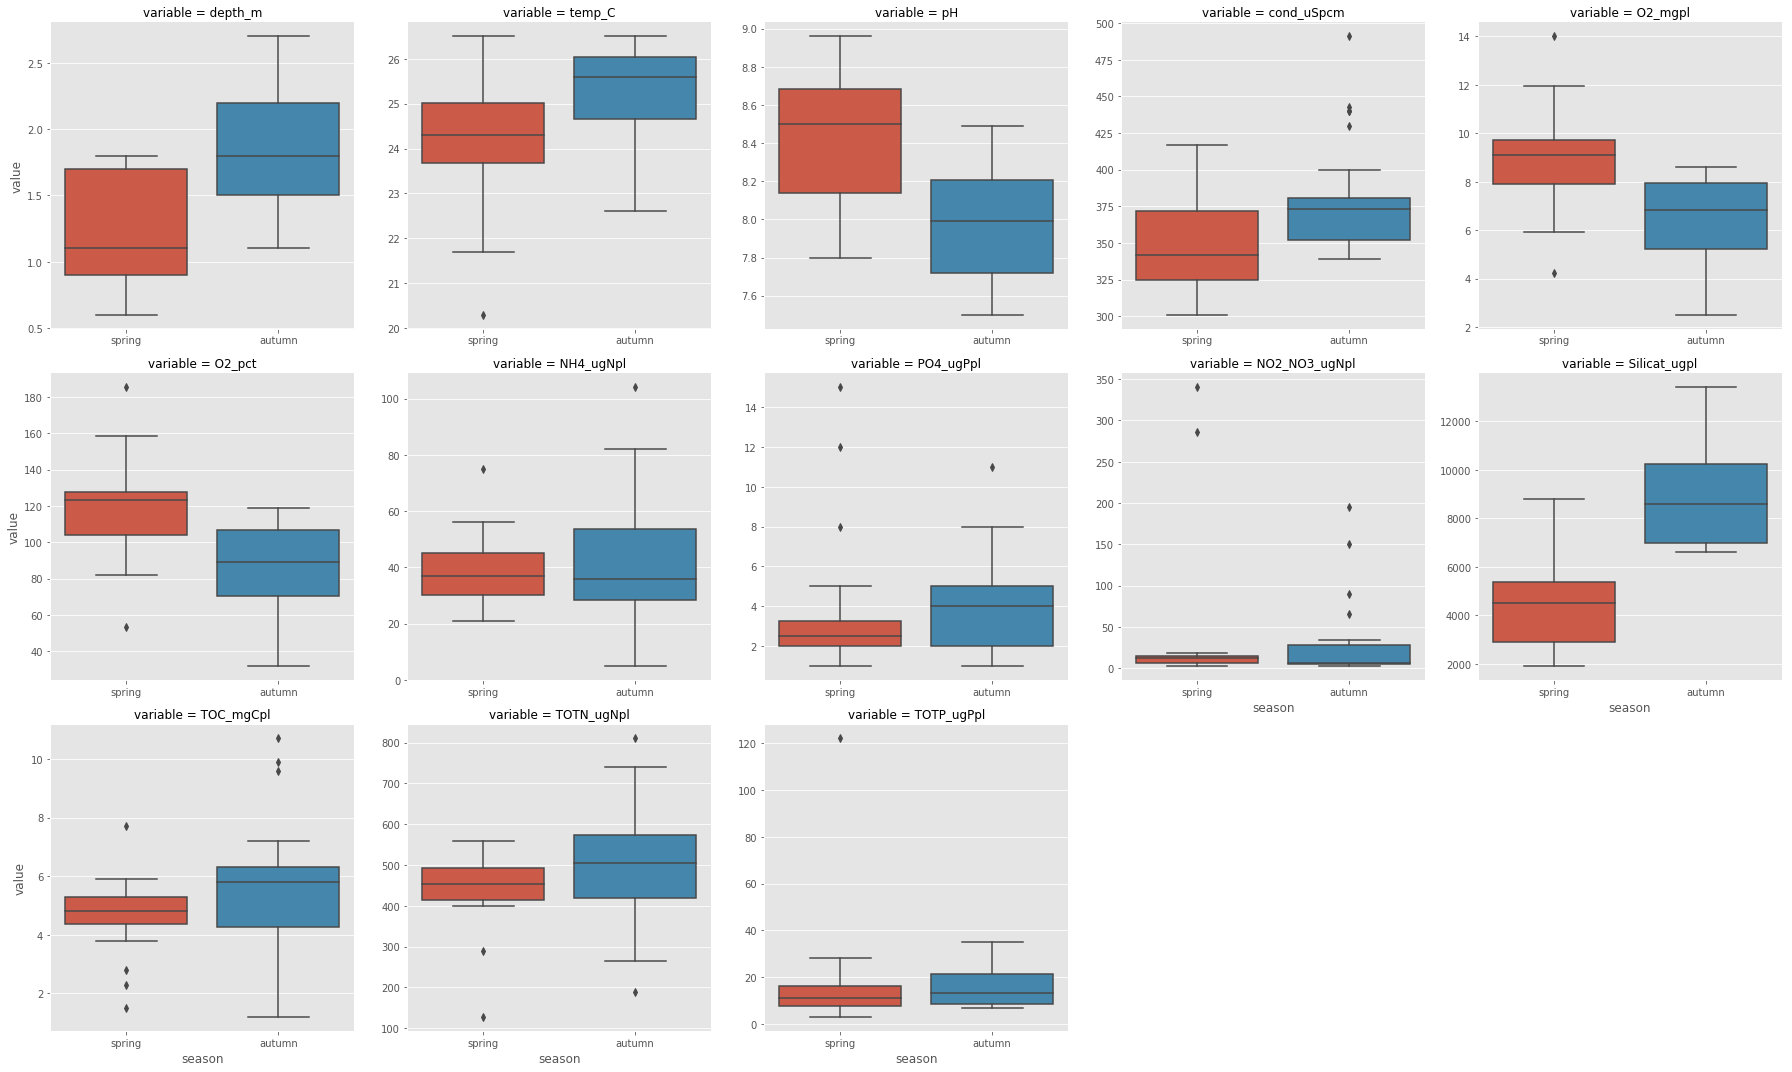

In [3]:
# Read data
chem_df = pd.read_excel(in_xlsx, sheet_name='chem_transposed')

# Convert </> LOD to LOD
for col in chem_df.columns:
    if col not in ['site', 'date']:
        table = str.maketrans(dict.fromkeys('<>'))
        chem_df[col] = chem_df[col].astype(str).str.translate(table).astype(float)

# Melt to long format
chem_df_lng = chem_df.melt(id_vars=['site', 'date']).dropna(subset=['value'])

# Add seasons
chem_df_lng['month'] = chem_df_lng['date'].dt.month
chem_df_lng['season'] = pd.cut(chem_df_lng['month'], 
                               bins=[0, 4, 12],
                               labels=['spring', 'autumn'])

# Plot
g = sn.catplot(data=chem_df_lng, 
               x='season', 
               y='value', 
               col='variable', 
               kind='box',
               col_wrap=5, 
               sharey=False,
               sharex=False)
plt.tight_layout()

From the above plots it is interesting to note that the measured depths are quite different between spring and autumn (autumn depths are deeper), even though the site locations should be the same. This implies either visiting slighly different locations each year, or that the whole lake typically becomes deeper as the year progresses.

Seasonal variations in temperature in this dataset are quite small: the spring mean is around 24 degrees, compared to about 25.5 degrees by the autumn. pH decreases slightly throughout the year, as does O2 saturation (presumably implying respiration/decay > photosynthesis by the end of the summer). There is also a significant increase in silicate concentrations between spring and autumn, but I'm not sure why this would be - perhaps riverine inputs (consistent with depths increasing), or due to the death & dissolution of diatoms or...? (Probably better to leave this interpretation to someone with some knowledge of ecology!) For most of the other variables, the differences between periods are small.

#### 2.1.2. Scatterplot matrix

**Note:** To avoid errors in seaborn, it is necessary to fill NaNs in the chemistry dataframe with zeros. This skews the histograms, so care is required when interpreting the plots below.

**Note 2:** In the plots below, I have filtered out a sample with TOTP > 120 ugP/l. This is a huge outlier, and it compresses the axis scale so much that other patterns are obscured.

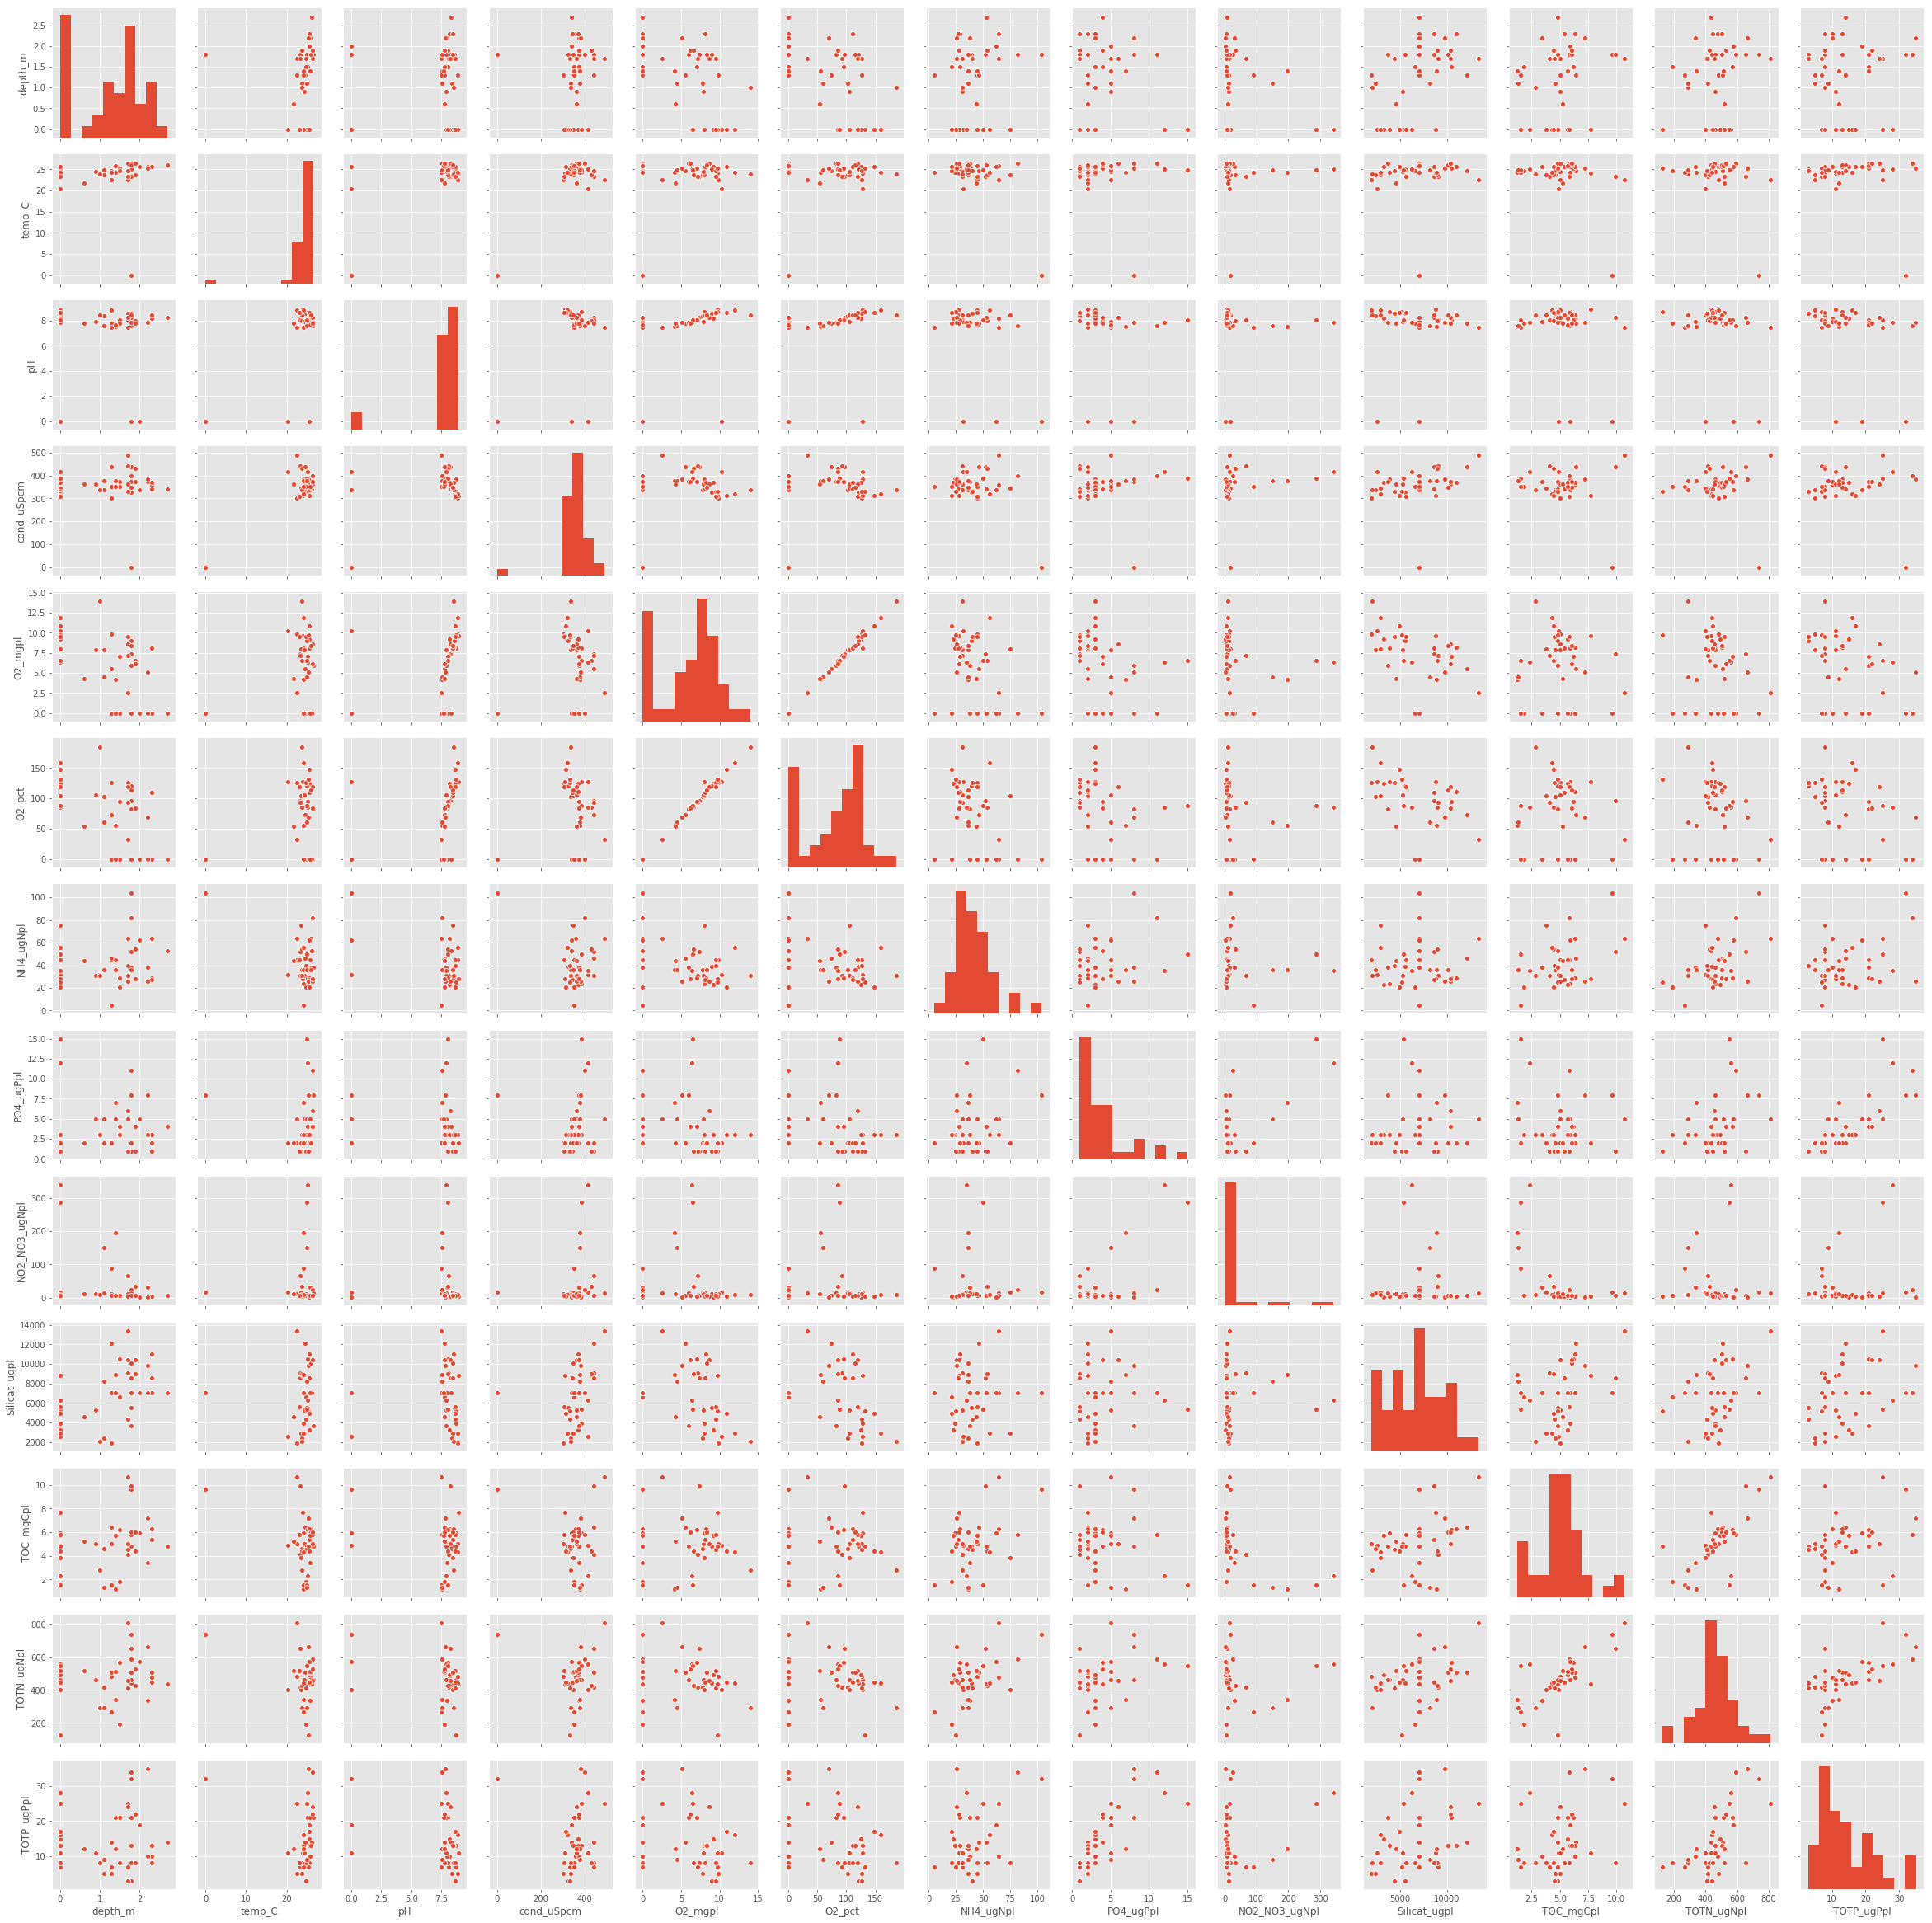

In [4]:
# Scatter matrix
df = chem_df.query("TOTP_ugPpl < 120")  # Remove TOTP outlier
sn.pairplot(df.fillna(0))

Basic relationshiops within the water chemistry dataset seem reasonable, Note that there is a clear positive relationship between TOTN and TOC, and also that whenever TOC is high, (NO3+NO2) is very low. This appears to suggest some degree of nitrate limitation (?) i.e. whenever NO3 is present it gets taken up very quickly and converted into organic N. I tend to think of freshwater systems as being P-limited, but there is less evidence of this in these data (and it's probably a very coarse rule-of-thumb anyway). There is also a weak correlation between silicate and TOC, which may indicate that a substantial proportion of the organic biomass is made up of e.g. diatoms (?).

The other thing that's surprising (at least to me, having never been to Inle) is just how low the nutirent concentrations are. I imagined the lake to be fairly heavily polluted, but in fact nutrient concentrations are low almost everywhere - certainly in comparison to the Scottish agricultural systems I'm familiar with.

### 2.2. Macrophytes

#### 2.2.1. Point plots

The code below first **cubes** all the semi-quantitative scores and then produces "jittered" point plots for each taxon, split by season (I'm using point plots rather than boxplots here because for several taxa we have only one or two points, so boxplots are a bit misleading).

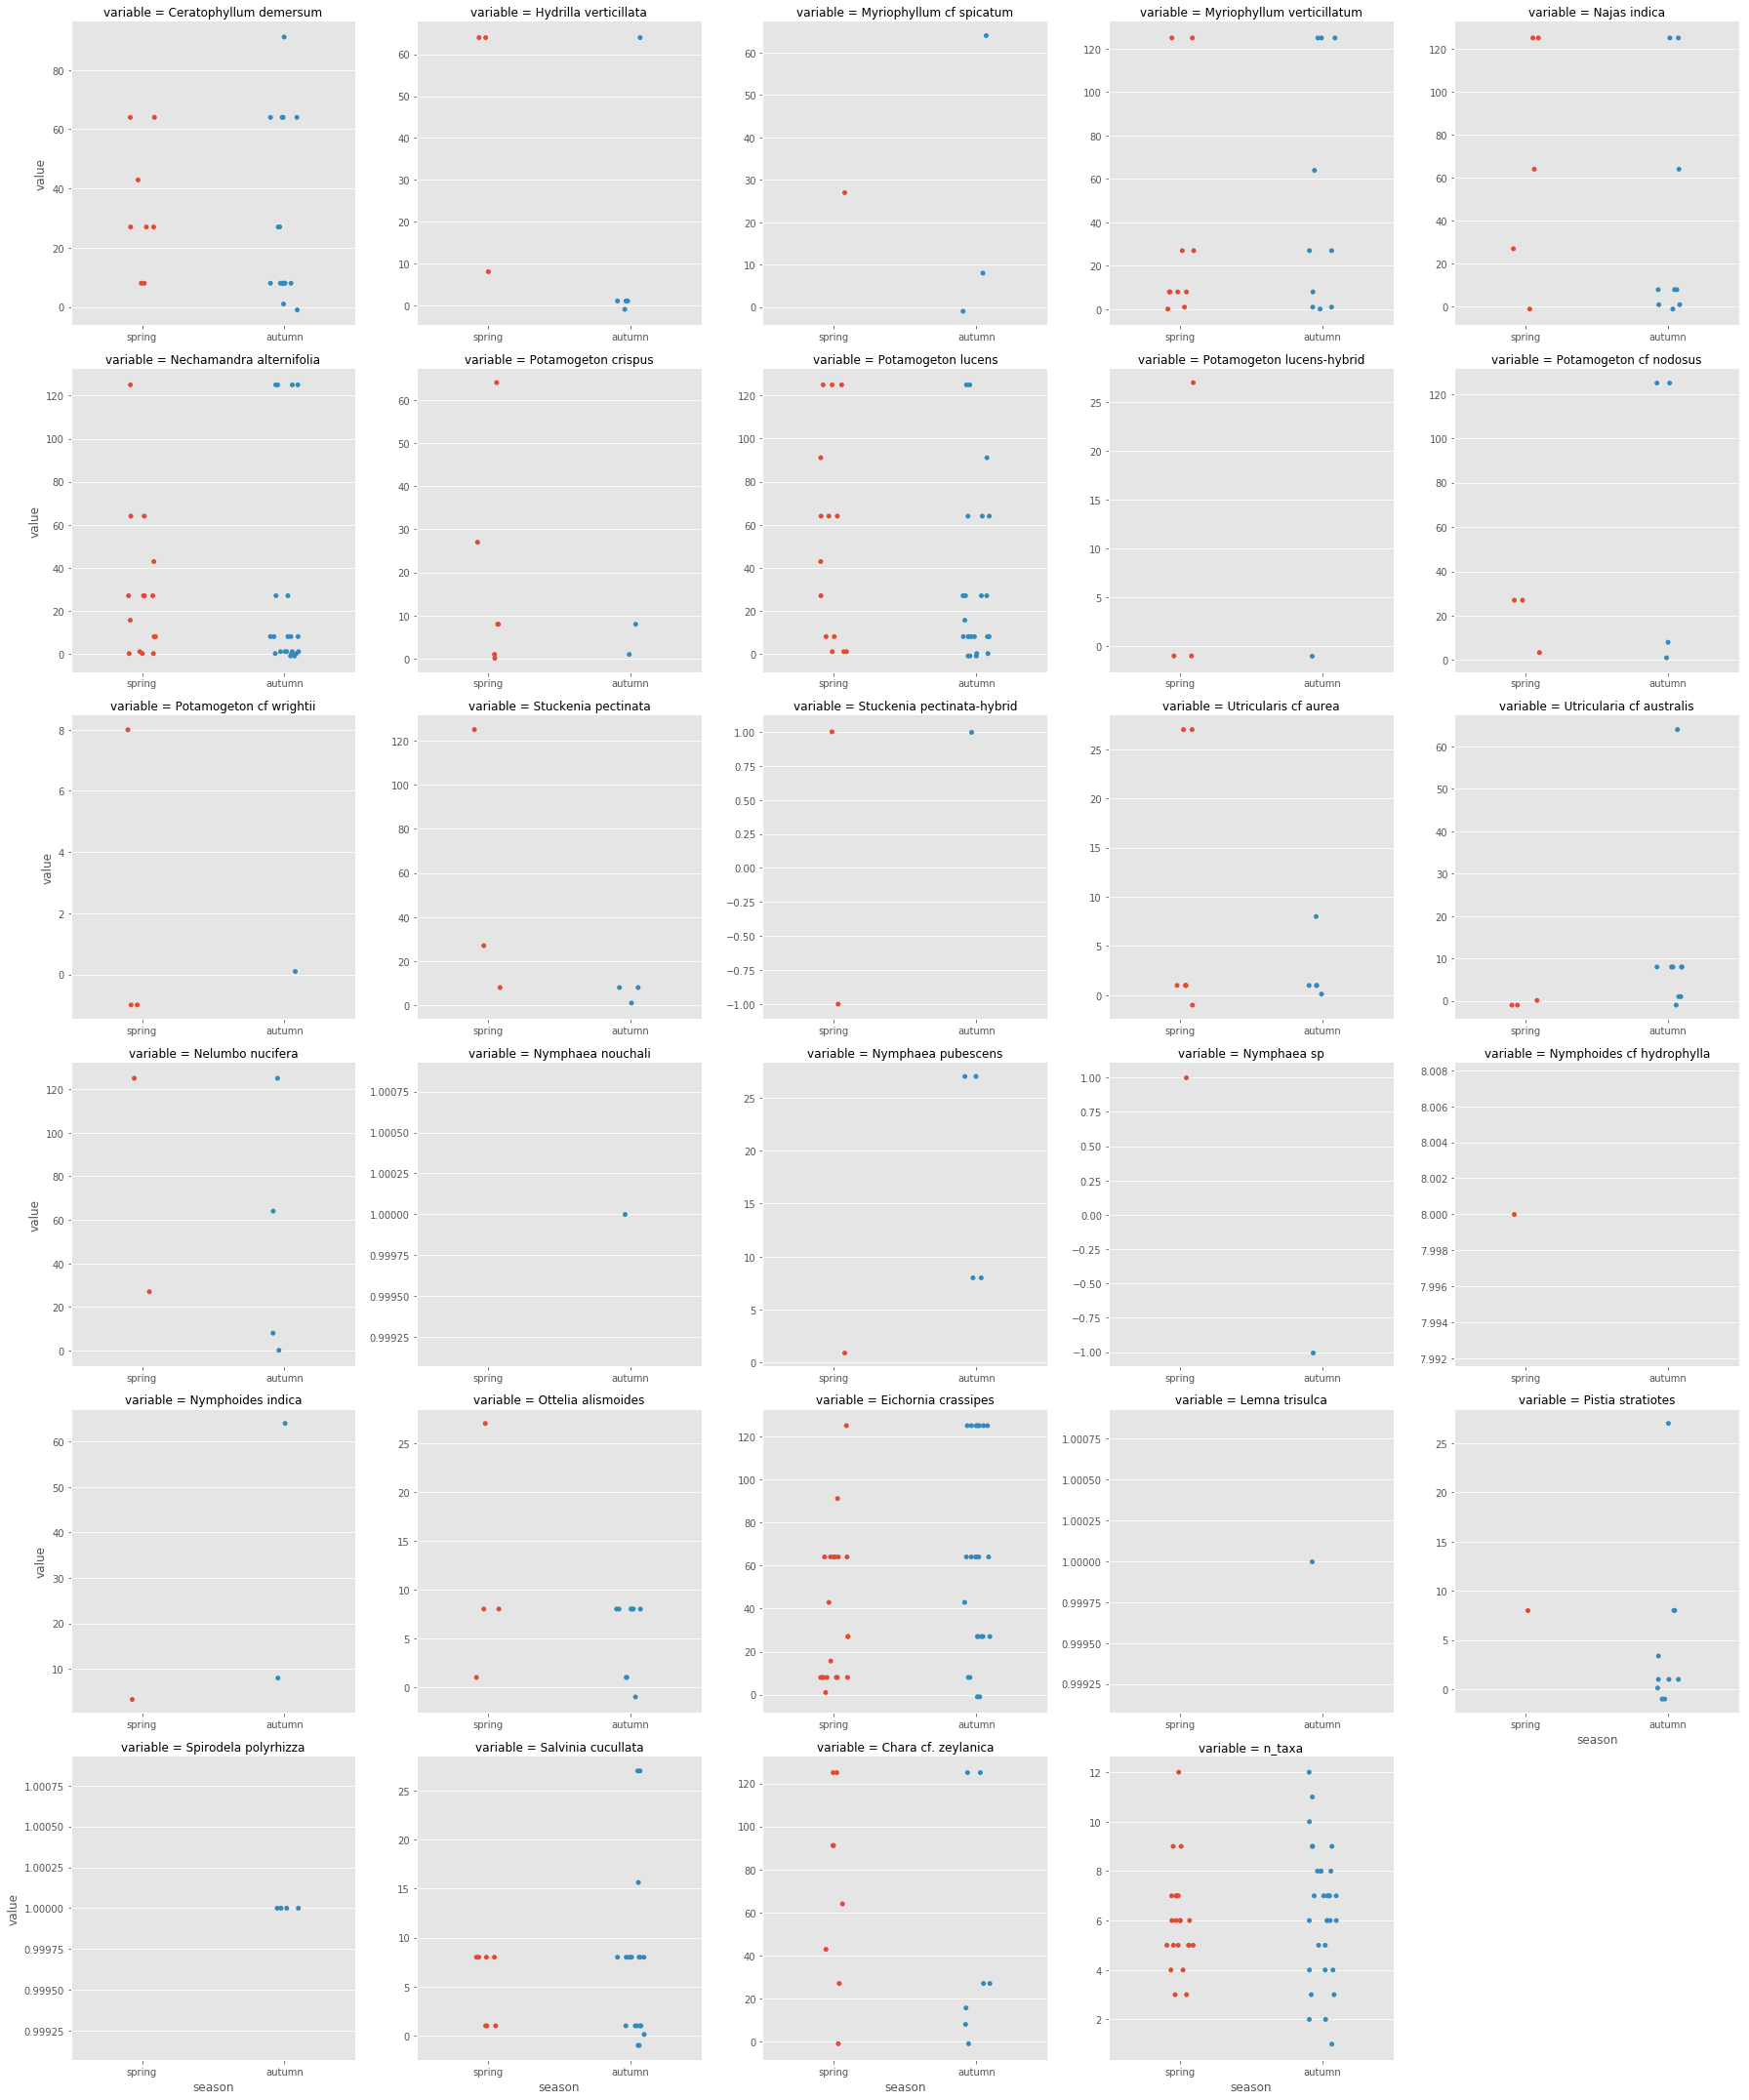

In [5]:
# Read data
mac_df = pd.read_excel(in_xlsx, sheet_name='macro_transposed')

# Cube semi-quant cols
for col in mac_df.columns:
    if col not in ['site', 'date', 'n_taxa']:
        mac_df[col] = mac_df[col]**3
        
# Melt to long format
mac_df_lng = mac_df.melt(id_vars=['site', 'date']).dropna(subset=['value'])

# Add seasons
mac_df_lng['month'] = mac_df_lng['date'].dt.month
mac_df_lng['season'] = pd.cut(mac_df_lng['month'], 
                              bins=[0, 4, 12],
                              labels=['spring', 'autumn'])

# Plot
g = sn.catplot(data=mac_df_lng, 
               x='season', 
               y='value', 
               col='variable', 
               col_wrap=5, 
               sharey=False,
               sharex=False)
plt.tight_layout()

Note the following:

 * When splitting by season, the data available for each taxon are quite sparse. For the statistcial analysis, we therefore probably need to aggregate over either time or taxa or both
 
 * There are no clear seasonal patterns for the individual taxa (i.e. no obvious evidence for spring or autumn having different distributions for any particular taxon). This suggests aggregating over time might be reasonable. This is possibly because the differences between seasons at Inle are not very pronounced, as illustrated by the temperature data in Section 2.1.

#### 2.2.2. Scatterplot matrix

The scatterplot matrix for the macrophytes is difficult to interpret due to the large number of NaNs. Overall, it does not seem very informative, so I haven't included it here.

### 2.3. Phytoplankton

#### 2.3.1. Boxplots

The boxplots below apply the same approach as above to the phytoplankton data. There is perhaps some  weak evidence for slightly higher biomass during the autumn, but nothing statistically significant.

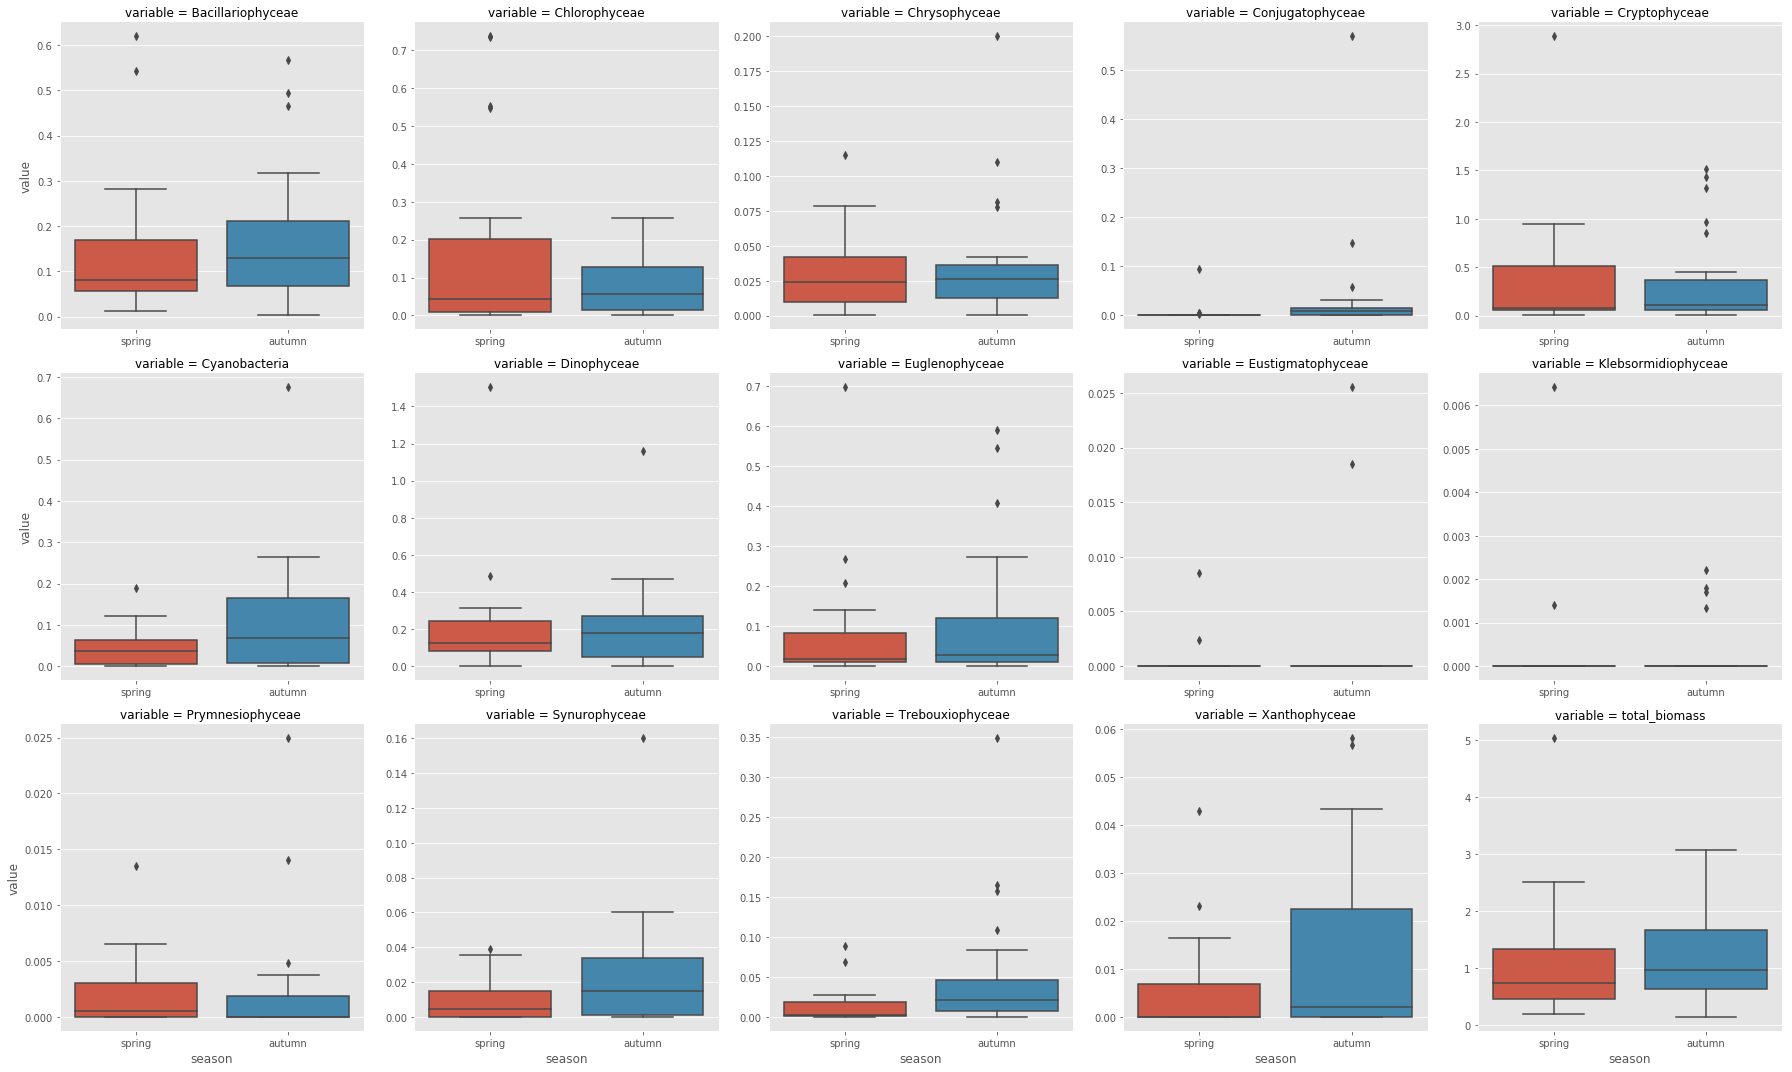

In [6]:
# Read data
phy_df = pd.read_excel(in_xlsx, sheet_name='phyto_transposed')

# Melt to long format
phy_df_lng = phy_df.melt(id_vars=['site', 'date']).dropna(subset=['value'])

# Add seasons
phy_df_lng['month'] = phy_df_lng['date'].dt.month
phy_df_lng['season'] = pd.cut(phy_df_lng['month'], 
                              bins=[0, 4, 12],
                              labels=['spring', 'autumn'])

# Plot
g = sn.catplot(data=phy_df_lng, 
               x='season', 
               y='value', 
               col='variable', 
               kind='box',
               col_wrap=5, 
               sharey=False,
               sharex=False)
plt.tight_layout()

#### 2.3.2. Scatterplot matrix

The matrix below does not show (m)any clear relationships between the different phytoplankton taxa. Based on this, I'd say that `'total_biomass'` is probably as good as anything in terms of identifying predictors for the statistical analysis.

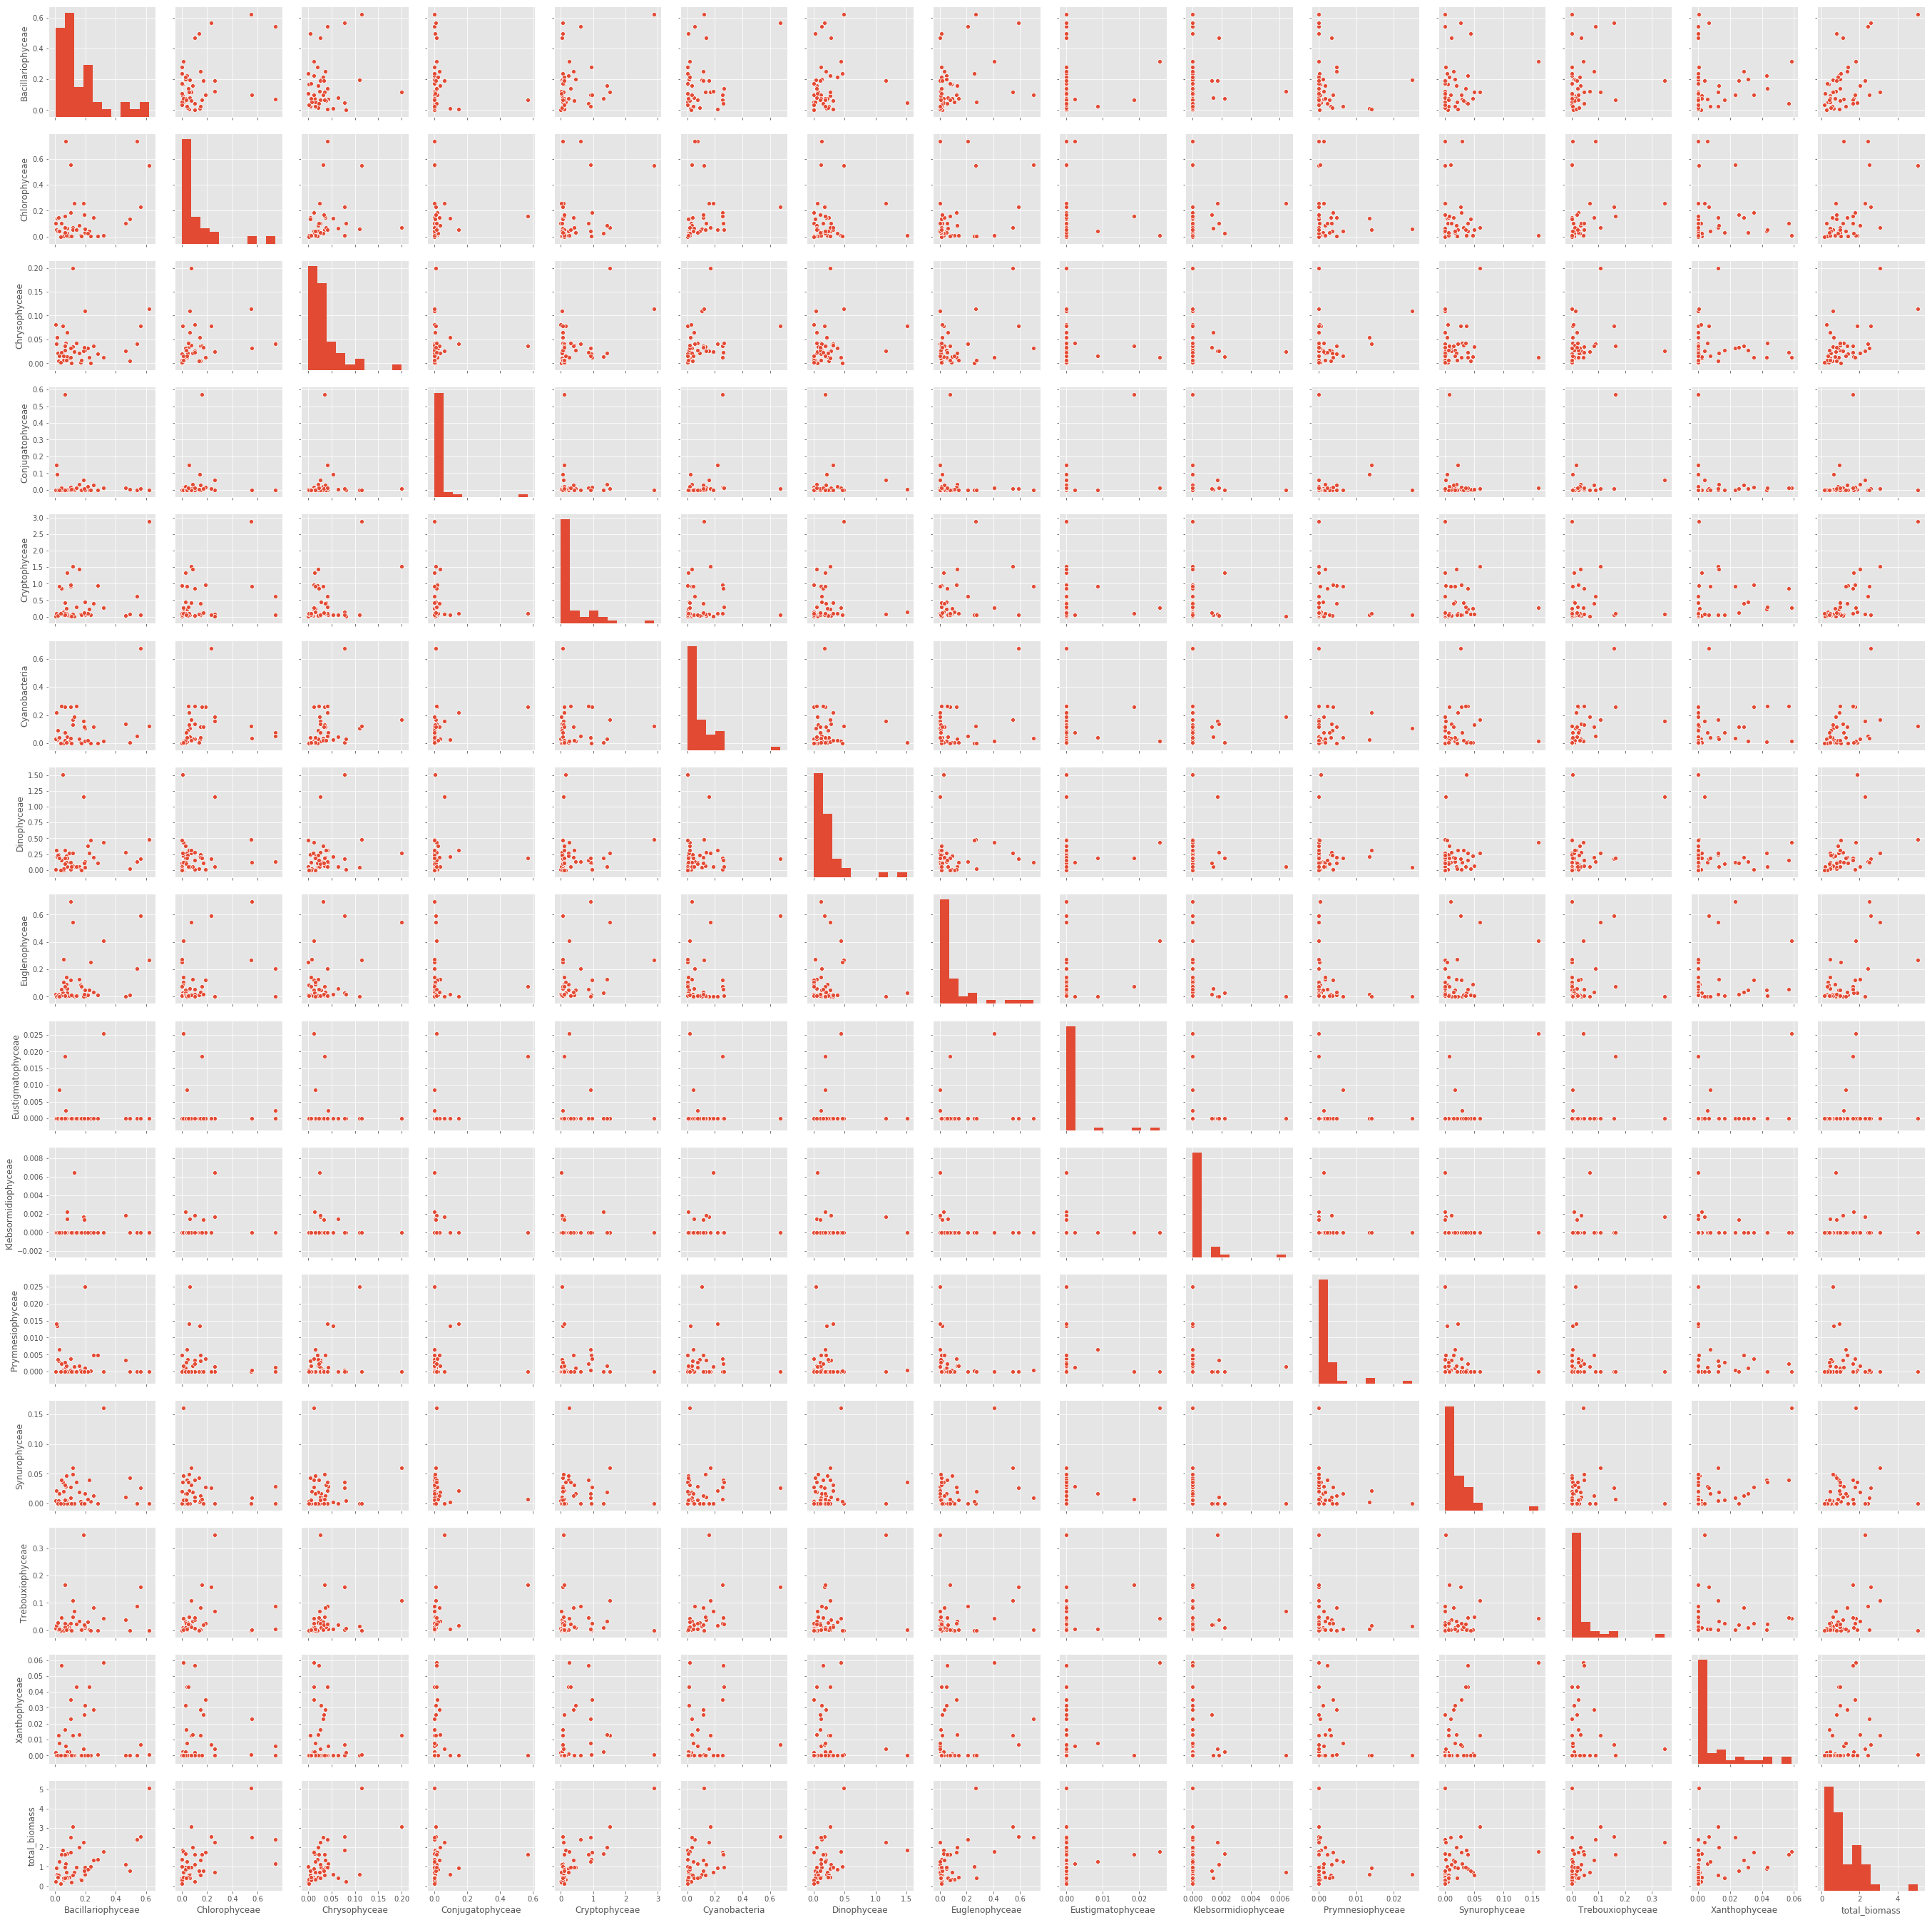

In [7]:
# Scatter matrix
sn.pairplot(phy_df.fillna(0))

## 3. Correlations between datasets

The code below joins all datasets together based on site and date, and then explores various relatiohsips between variables. Note that for the moment I'm aggregating everything to monthly resolution by taking means, because I don't have precise sampling dates for the macrophyte surveys. For example, in the physico-chemical data, site A1 was visited twice during November 2015 (once on the 5th and once on the 22nd), whereas the macrophyte data just reports a single survey from November 2015. I don't know which of the water chemistry surveys this corresponds to, so for now I'll just average the chemistry data for November 2015 and then link this to the macrophyte data.

**Note:** As above, for clarity I'm removing the outlier sample with TOTP > 120 ugP/l.

In [8]:
# Truncate dates to monthly
chem_df['date'] = chem_df['date'].dt.to_period('M') 
mac_df['date'] = mac_df['date'].dt.to_period('M') 
phy_df['date'] = phy_df['date'].dt.to_period('M') 

# Resample to monthly
chem_df_mon = chem_df.groupby(['site', 'date']).mean().reset_index()
mac_df_mon = mac_df.groupby(['site', 'date']).mean().reset_index()
phy_df_mon = phy_df.groupby(['site', 'date']).mean().reset_index()

# Join
mon_df = pd.merge(chem_df_mon, mac_df_mon, on=['site', 'date'])
mon_df = pd.merge(mon_df, phy_df_mon, on=['site', 'date'])

# Remove outlier
mon_df = mon_df.query('TOTP_ugPpl < 120')

Showing a single scatter matrix for the whole dataset is too large/cumbersome to be interpreted meaningfully. Instead, the code below define a convenience function to produce scatter matrices for each pair of datasets.

In [9]:
def scatter_matrix(x_df, y_df, all_df, size=(30,30)):
    """ Quick convenience function for scatter plot matrix.
    """
    # Get rows and cols for plotting
    y_cols = [i for i in y_df.columns if i not in ['site', 'date']]
    x_cols = [i for i in x_df.columns if i not in ['site', 'date']]

    # Setup plot
    fig, axes = plt.subplots(nrows=len(y_cols),
                             ncols=len(x_cols),
                             sharex=False,
                             sharey=False,
                             figsize=size)

    # Loop over data
    for row, y_col in enumerate(y_cols):
        for col, x_col in enumerate(x_cols):
            # Plot
            axes[row, col].plot(mon_df[x_col], mon_df[y_col], 'ro')
            if row == (len(y_cols) - 1):
                axes[row, col].set_xlabel(x_col)
            if col == 0:
                axes[row, col].set_ylabel(y_col.replace(' ', '\n'))
    plt.tight_layout()

### 3.1. Phytoplankton and chemistry

Total phytoplankton biomass shows a weak positive relationship with TOC, which makes sense, plus weak positive relationships with nutrients (TOTN and TOTP). Otherwise relationships seem noisy/unobvious.

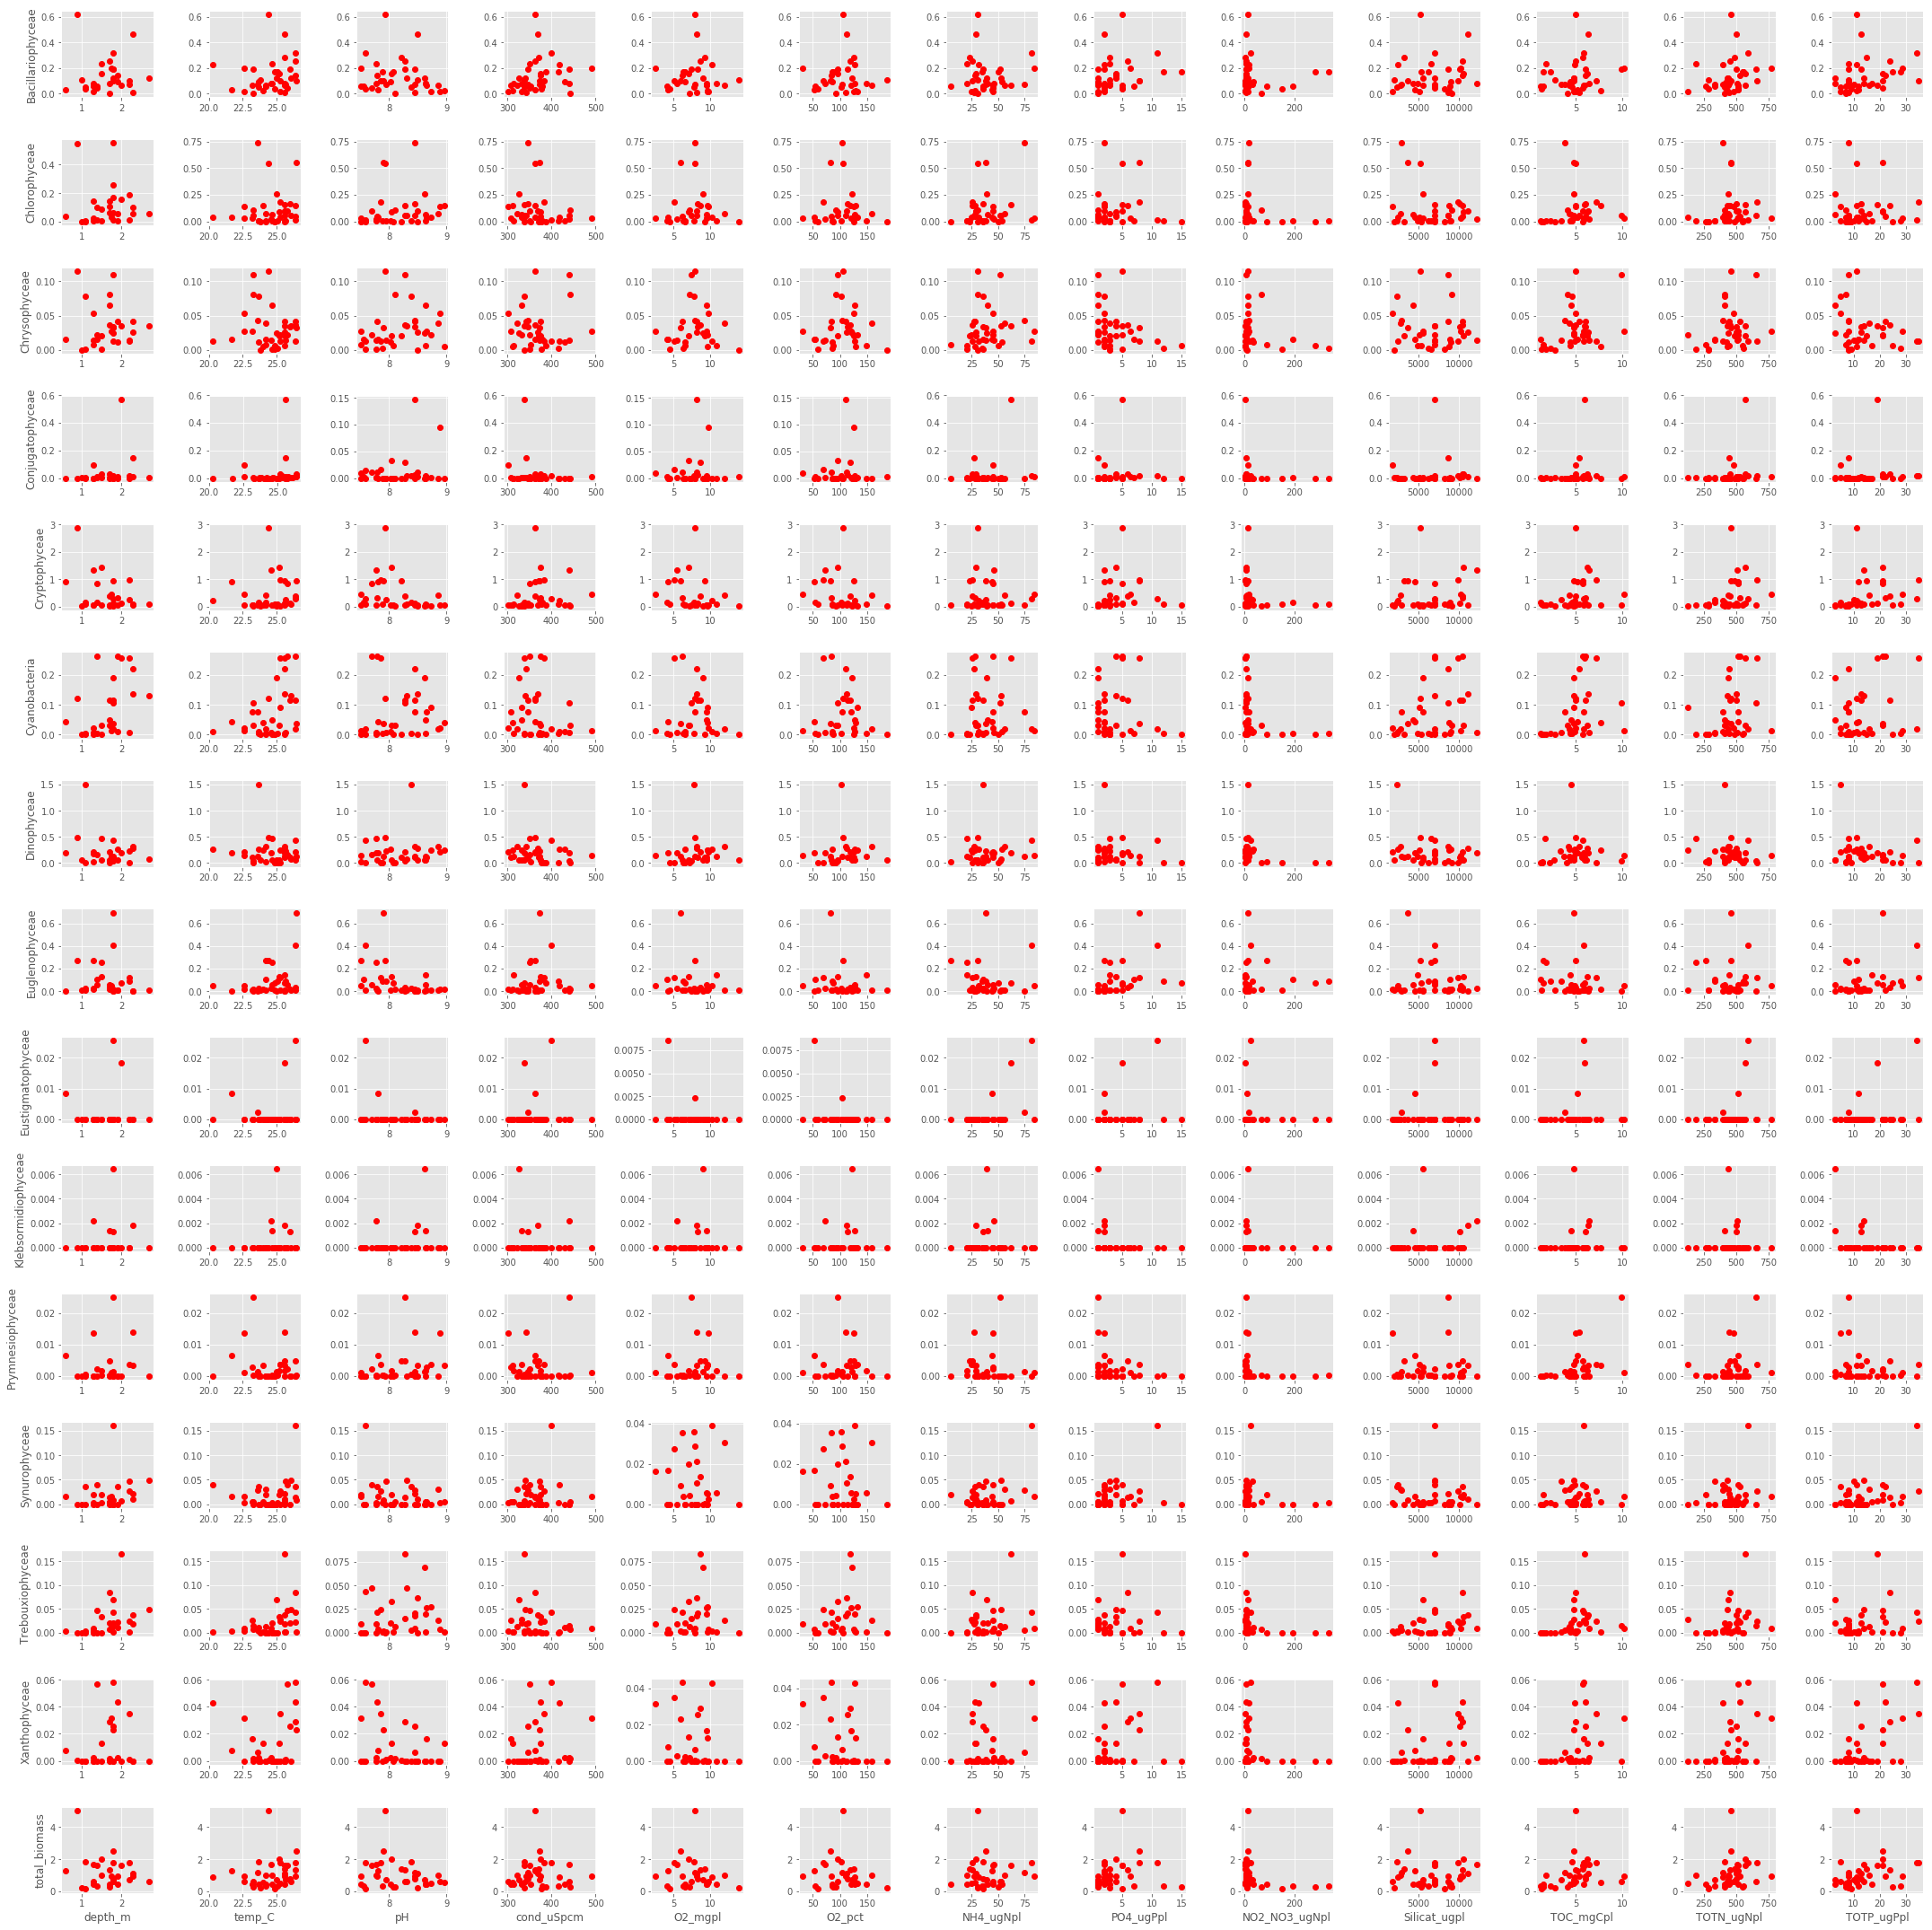

In [10]:
# Phy vs. Chem
scatter_matrix(chem_df, phy_df, mon_df)

### 3.2. Macrophytes and chemistry

It is difficult to pick out anything meaningful here, due to the limited occurrence of different macrophyte taxa (i.e. many values are NaN) and the semi-quantitative nature of the data. There is perhaps (very) weak evdience that more TOTP is associated with greater macrophyte diversity (i.e. `'n_taxa'` is higher). Otherwise nothing very obvious.

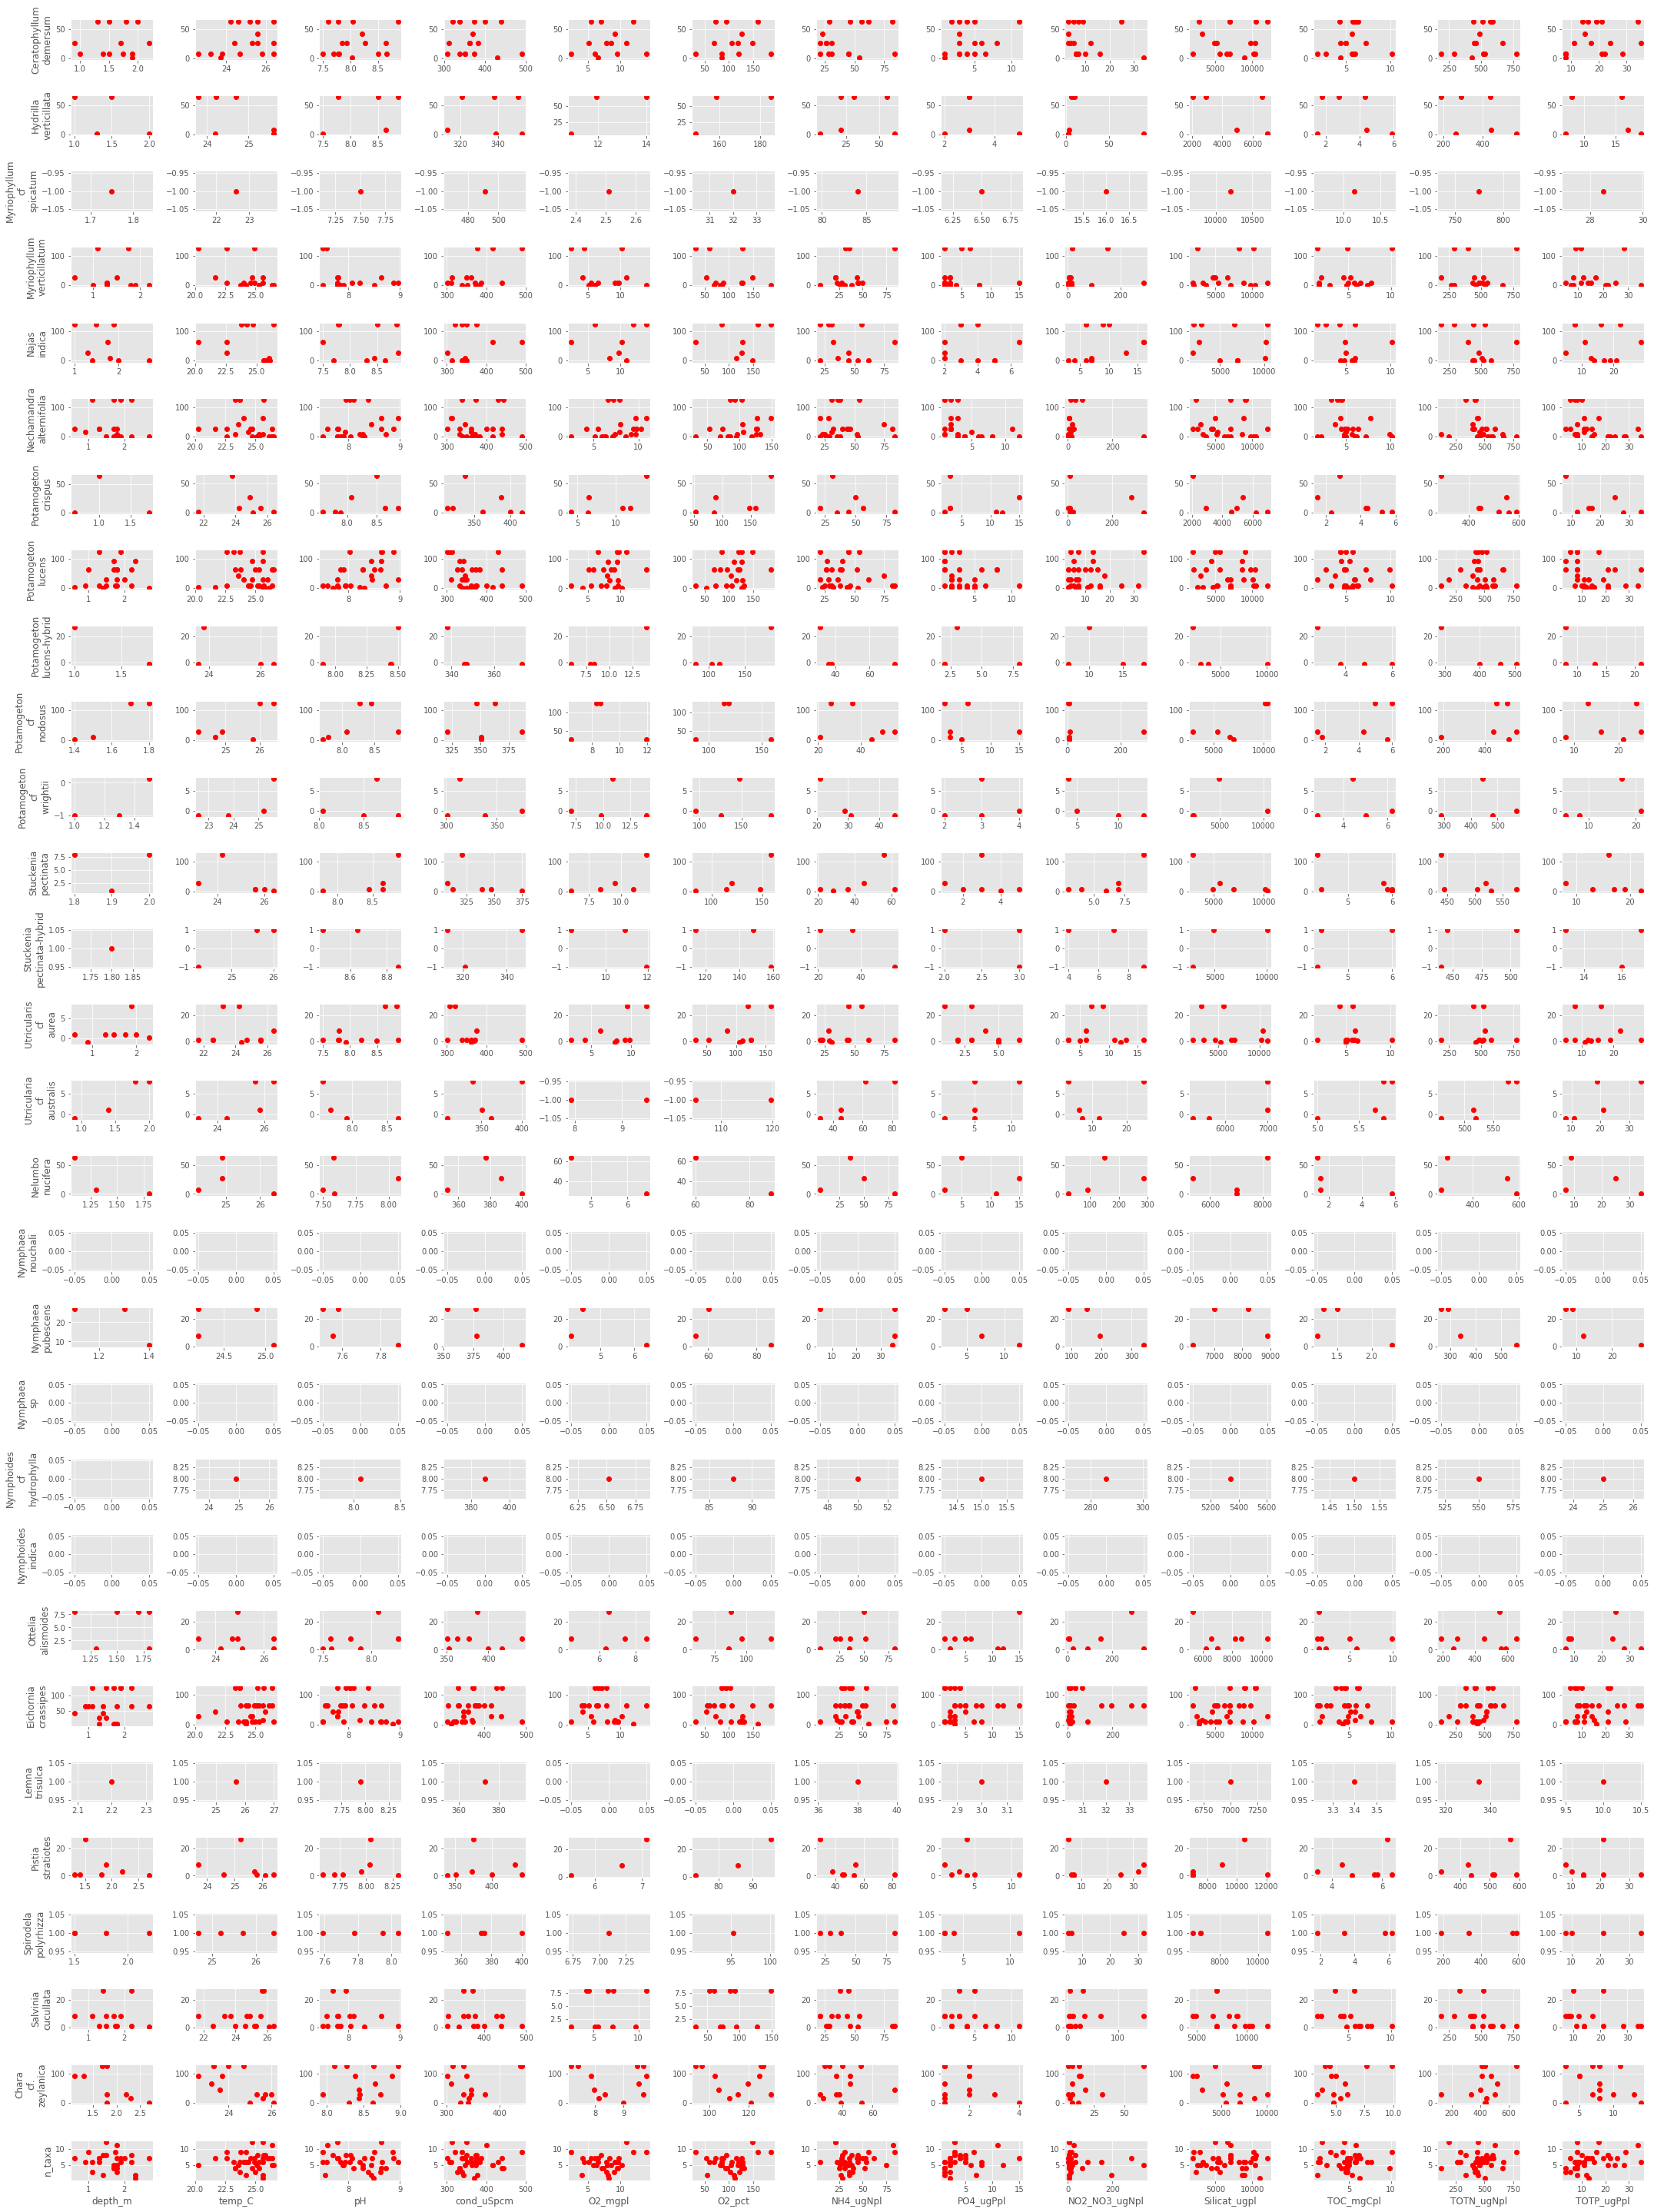

In [11]:
# Mac vs. Chem
scatter_matrix(chem_df, mac_df, mon_df, size=(30, 40))

### 3.3. Macrophytes and phytoplankton

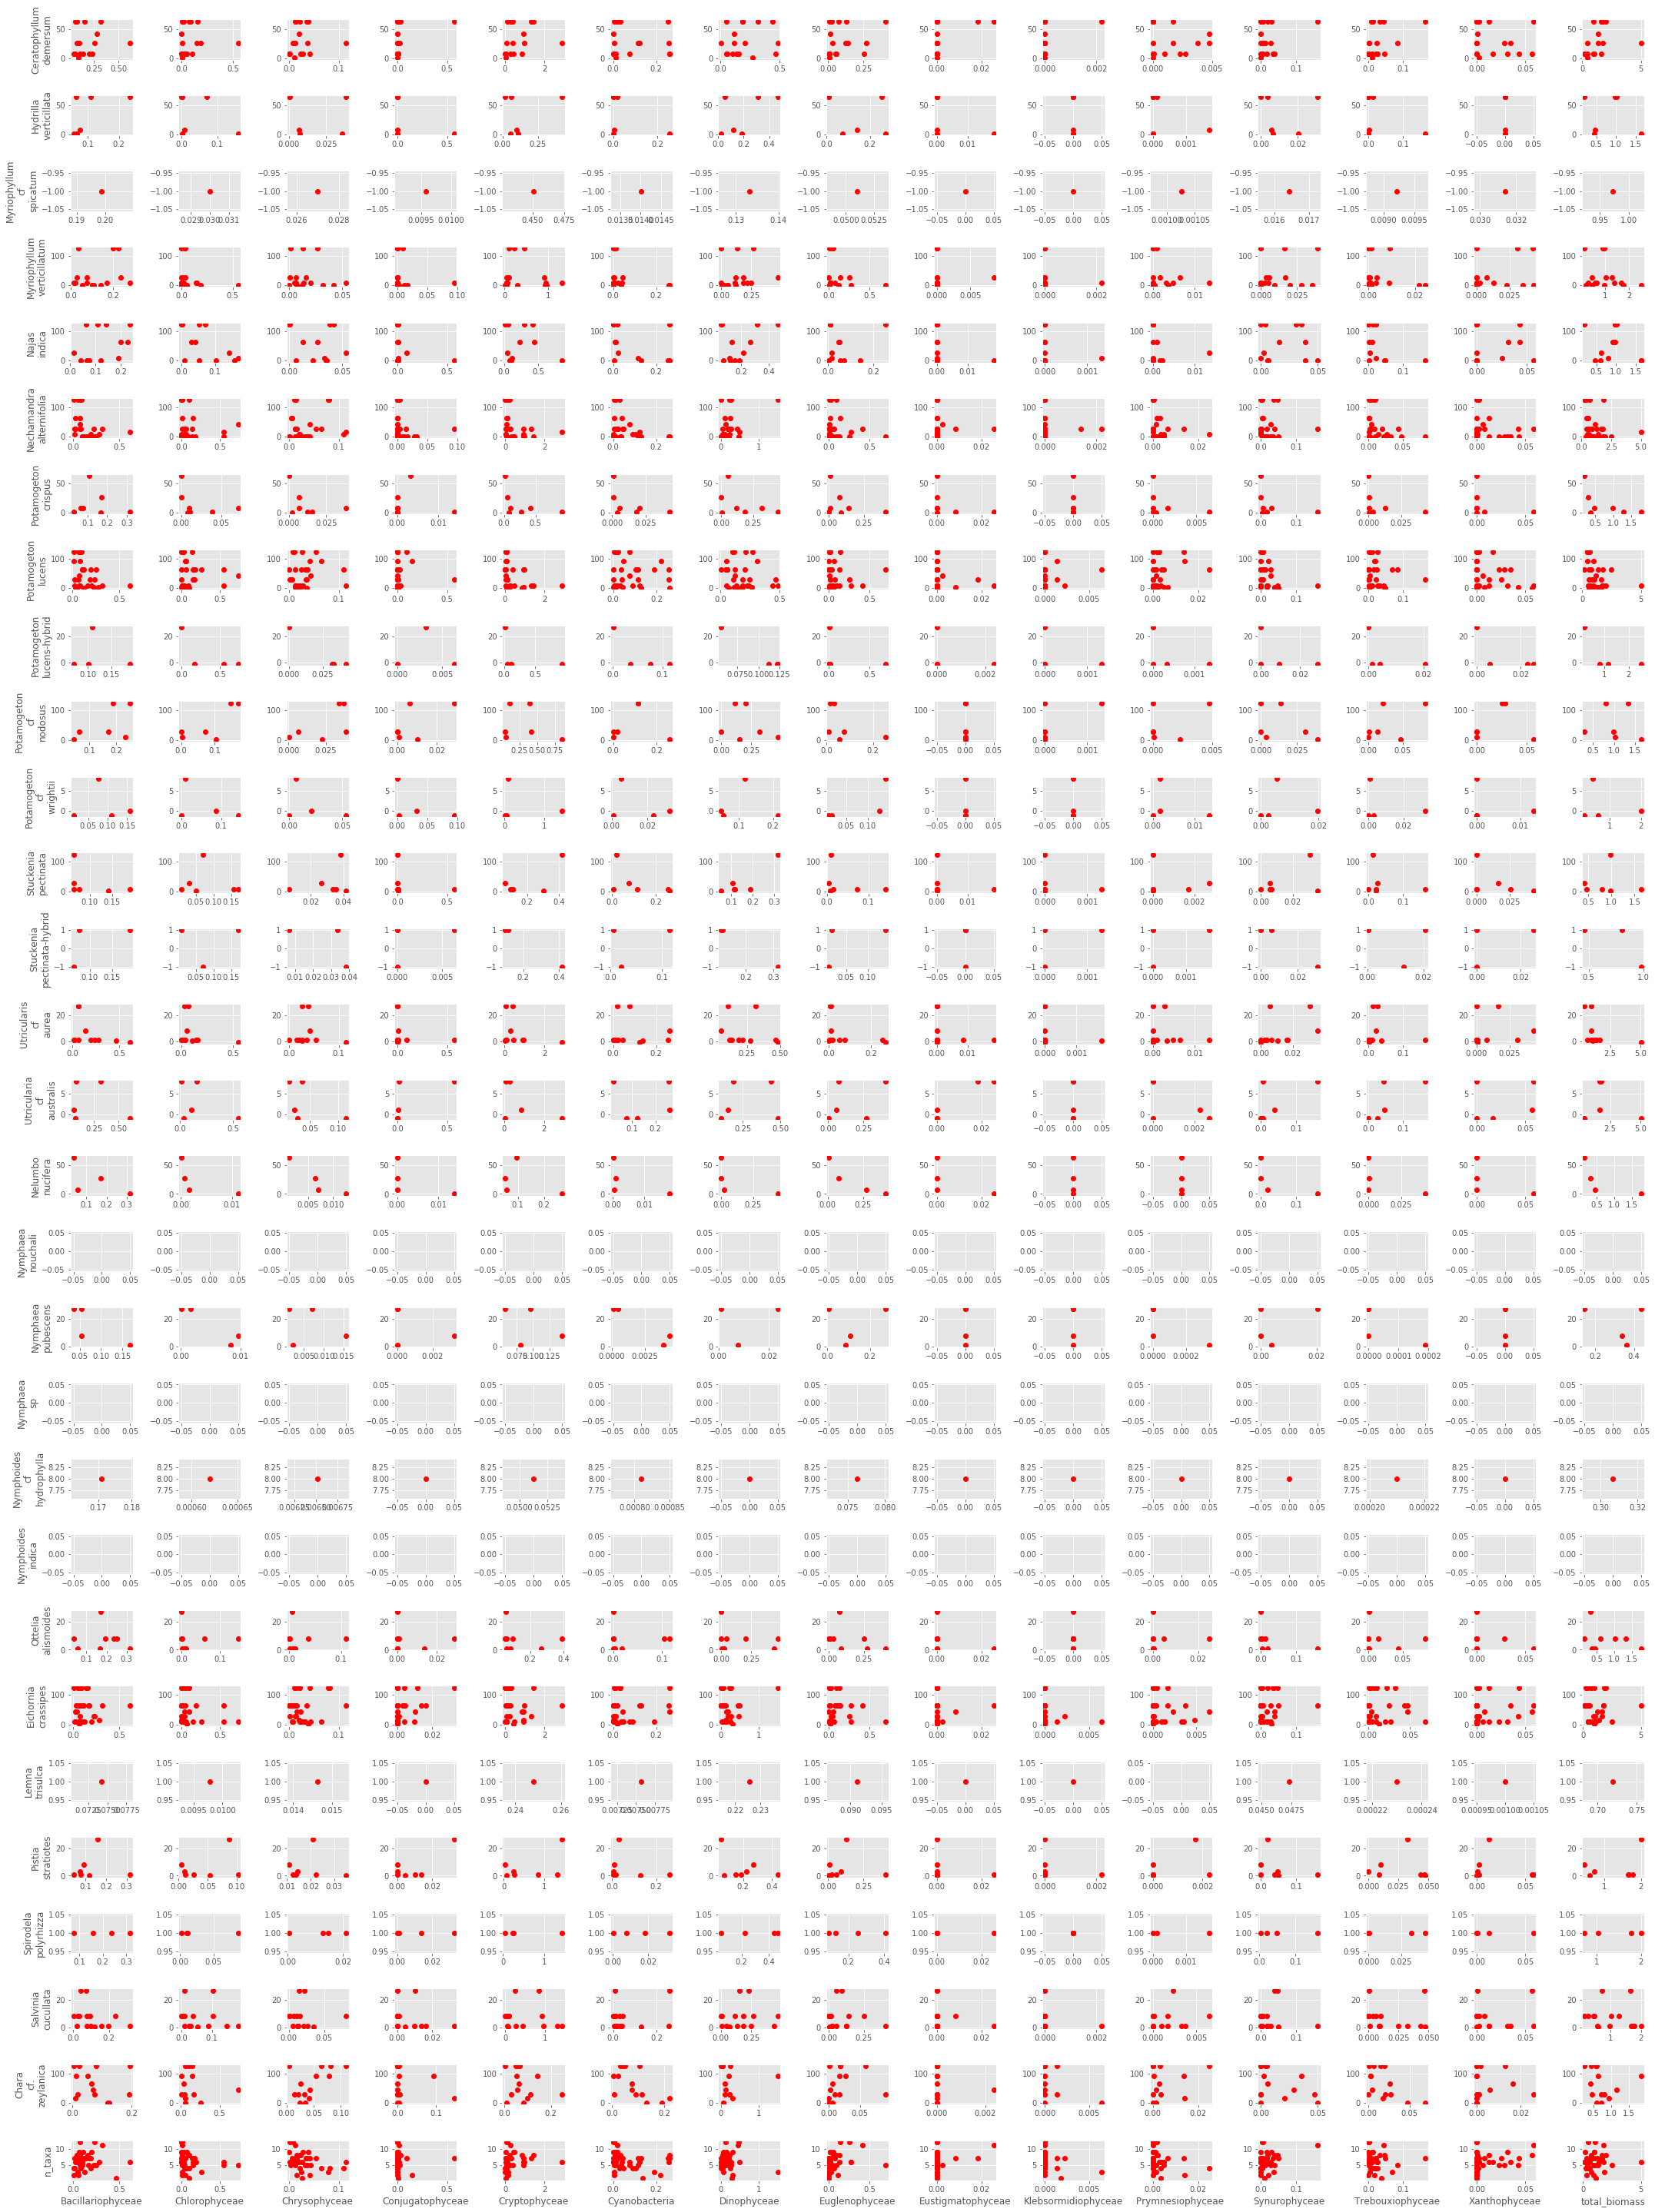

In [12]:
# Mac vs. Phy
scatter_matrix(phy_df, mac_df, mon_df, (30,40))

## 4. Summary

The three datasets appear reasonable, but there is a lot of noise and it is difficult to pick out any clear relationships. Based on the simple analysis so far:

 * The physico-chemical dataset shows some interesting seasonal patterns relating to hydrology (i.e. water depth), oxygen saturation and silicate
 
 * There is weak eveidence of a positive correlation between various phytoplankton taxa and nutrients (C, N and P). Roughly the same pattern can be applied to total phytoplankton biomass
 
 * There is weak evidence that increased TOTP is associated with greater macrophyte diversity (`'n_taxa'`)
 
Given the noise in the data and the very large number of possible variable combinations, it will be necessary to specify some hypotheses to test before going any further with the statistical analysis (because it is very easy to end up "data-dredging" with these kinds of data). Discuss further with Marit and Andreas.